In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pathlib import Path
from PIL import Image
from collections import Counter
import json
import cv2
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings("ignore")

In [16]:
# Set paths
data_dir = Path("../data/raw/PlantVillage")

In [15]:
# Get all image files
all_images = []
class_names = []

for class_dir in data_dir.iterdir():
    if class_dir.is_dir():
        class_name = class_dir.name
        images = list(class_dir.glob("*.jpg")) + list(class_dir.glob("*.JPG")) + list(class_dir.glob("*.png"))
        for img_path in images:
            all_images.append(img_path)
            class_names.append(class_name)

print(f"Total images found: {len(all_images)}")
print(f"Total classes: {len(set(class_names))}")

# Create results dictionary
quality_results = {
    'image_path': [],
    'class_name': [],
    'blur_score': [],
    'brightness': [],
    'noise_level': [],
    'sharpness': []
}

Total images found: 20637
Total classes: 15


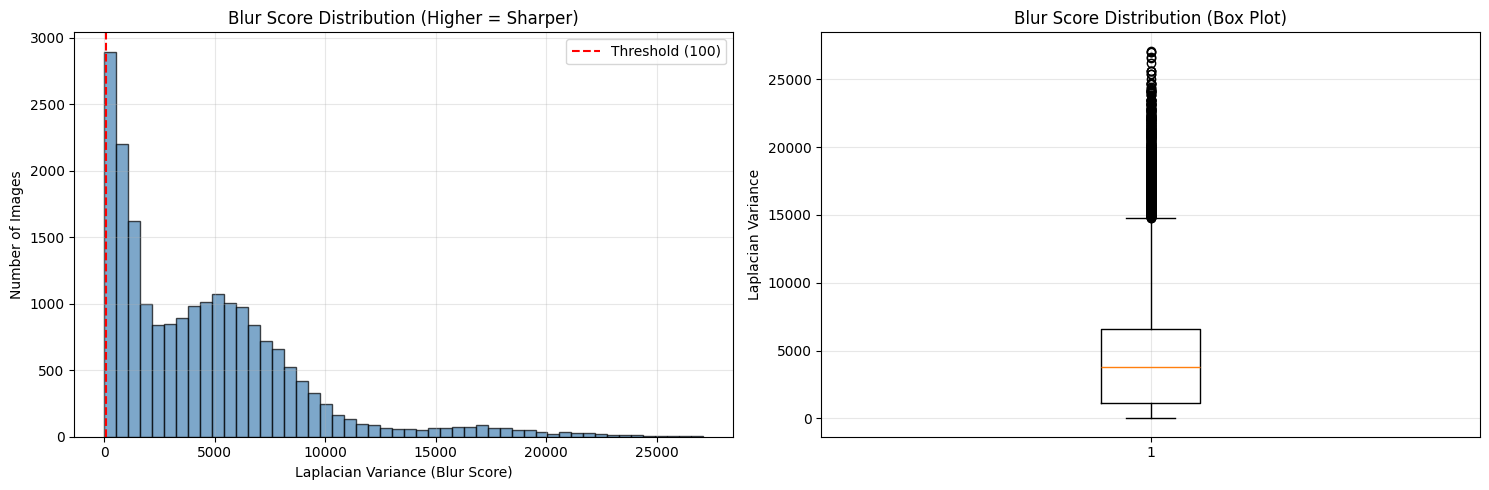


Blur Analysis Results:
Mean blur score: 4552.44
Median blur score: 3818.43
Std deviation: 4237.37
Potentially blurry images (< 100): 845 (4.09%)

Sample Images:


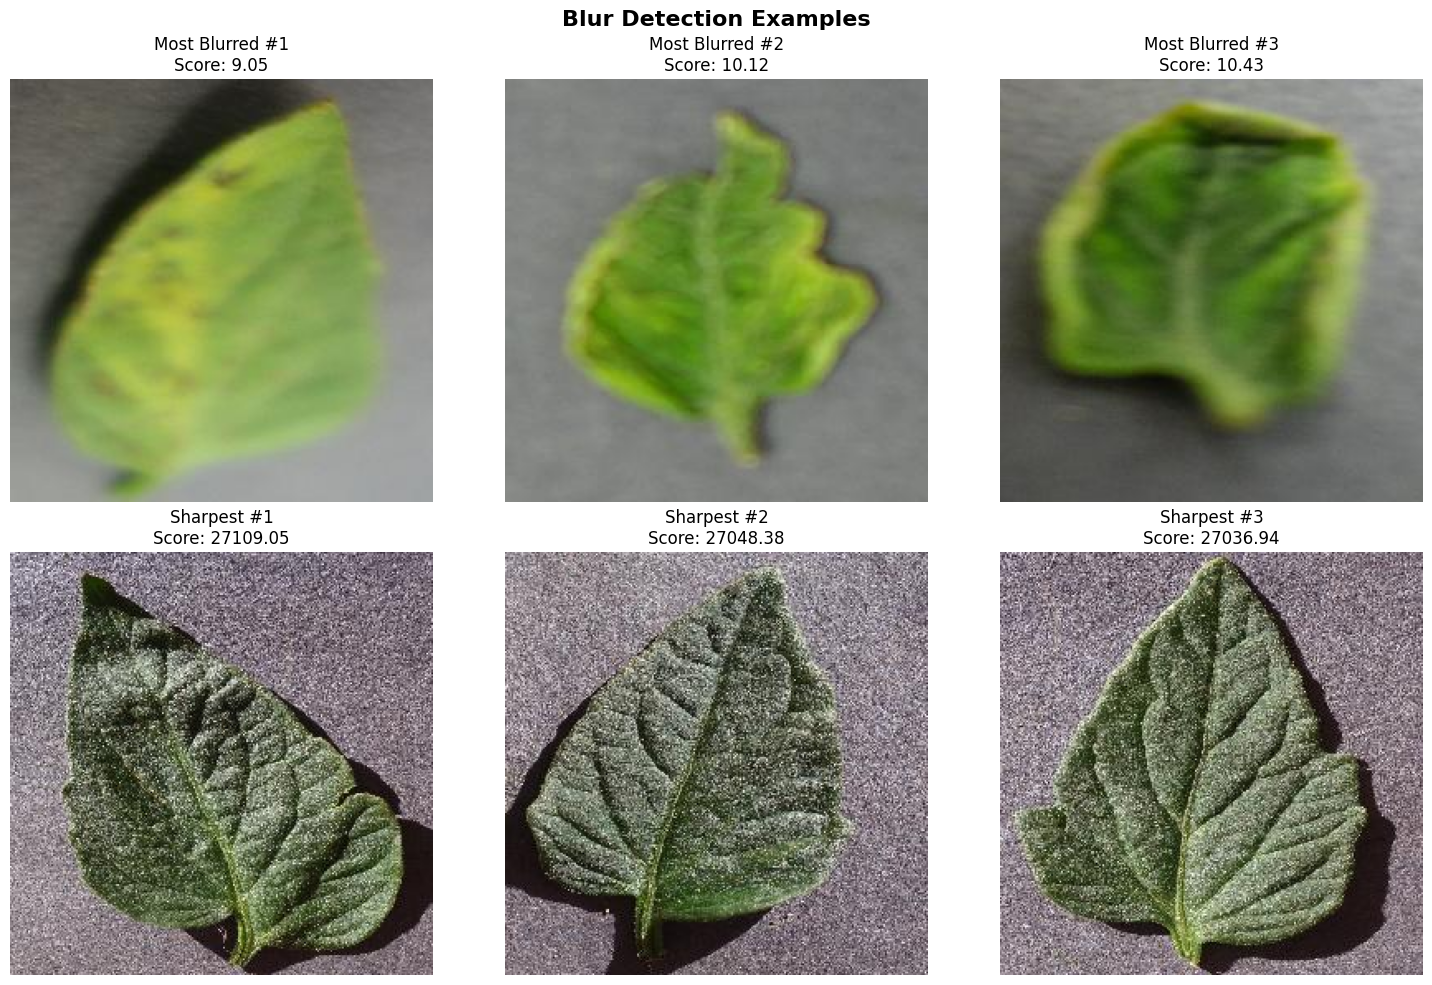

In [4]:
#Blur Detection (Laplacian Variance)
def detect_blur(image_path, threshold=100):
    """
    Detect blur using Laplacian variance.
    Lower values = more blurred
    """
    image = cv2.imread(str(image_path))
    if image is None:
        return None
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    laplacian_var = cv2.Laplacian(gray, cv2.CV_64F).var()
    return laplacian_var

# Analyze blur for all images
blur_scores = []
for img_path in all_images:
    blur_score = detect_blur(img_path)
    blur_scores.append(blur_score if blur_score is not None else 0)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram
axes[0].hist(blur_scores, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].axvline(x=100, color='red', linestyle='--', label='Threshold (100)')
axes[0].set_xlabel('Laplacian Variance (Blur Score)')
axes[0].set_ylabel('Number of Images')
axes[0].set_title('Blur Score Distribution (Higher = Sharper)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Box plot
axes[1].boxplot(blur_scores, vert=True)
axes[1].set_ylabel('Laplacian Variance')
axes[1].set_title('Blur Score Distribution (Box Plot)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistics
blur_threshold = 100
blurry_count = sum(1 for score in blur_scores if score < blur_threshold)
print(f"\nBlur Analysis Results:")
print(f"Mean blur score: {np.mean(blur_scores):.2f}")
print(f"Median blur score: {np.median(blur_scores):.2f}")
print(f"Std deviation: {np.std(blur_scores):.2f}")
print(f"Potentially blurry images (< {blur_threshold}): {blurry_count} ({blurry_count/len(blur_scores)*100:.2f}%)")

# Show examples
print("\nSample Images:")
sorted_indices = np.argsort(blur_scores)
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Blur Detection Examples', fontsize=16, fontweight='bold')

for i in range(3):
    # Most blurred
    idx = sorted_indices[i]
    img = Image.open(all_images[idx])
    axes[0, i].imshow(img)
    axes[0, i].set_title(f'Most Blurred #{i+1}\nScore: {blur_scores[idx]:.2f}')
    axes[0, i].axis('off')
    
    # Least blurred (sharpest)
    idx = sorted_indices[-(i+1)]
    img = Image.open(all_images[idx])
    axes[1, i].imshow(img)
    axes[1, i].set_title(f'Sharpest #{i+1}\nScore: {blur_scores[idx]:.2f}')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

# Store results
quality_results['blur_score'] = blur_scores

## Blur Analysis Key Findings

- **95.91%** of images are sharp (score ≥ 100) AND dataset is in good shape.
- **845 images (4.09%)** are severely blurry (score < 100) and should be **removed** before training.
- High std deviation (4237) reflects a bimodal dataset: a small blurry cluster and a large sharp majority.

> **Action:** Filter out images with Laplacian Variance < 100. Audit per-class impact to avoid worsening class imbalance.

Analyzing brightness levels


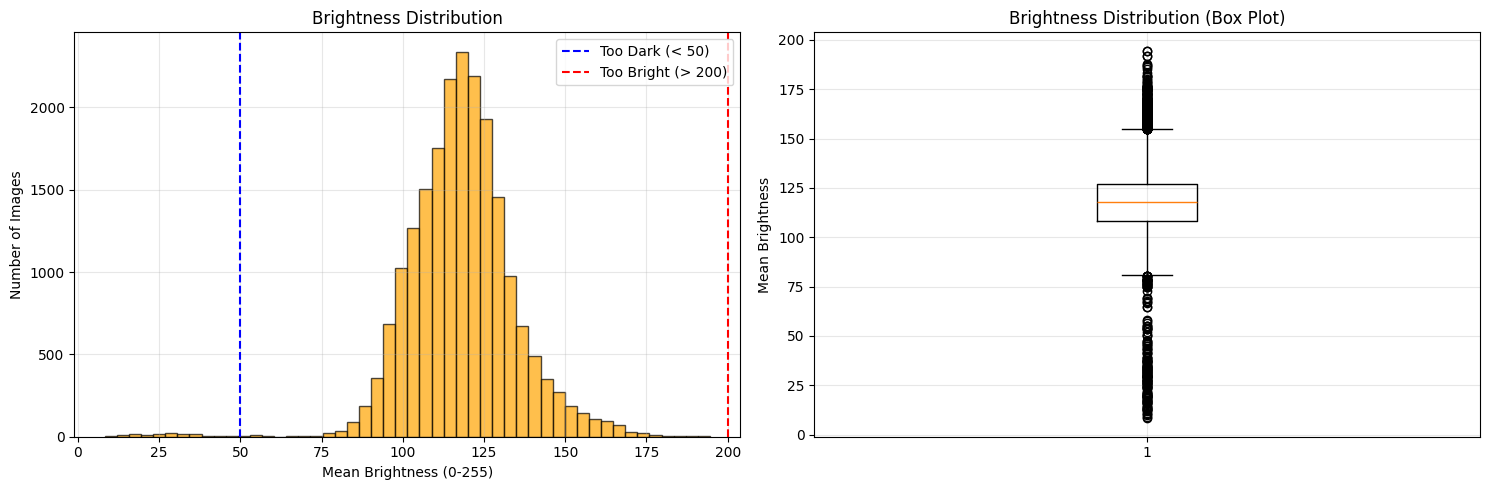


Brightness Analysis Results:
Mean brightness: 118.05
Median brightness: 118.06
Std deviation: 16.79
Too dark images (< 50): 138 (0.67%)
Too bright images (> 200): 0 (0.00%)

Sample Images:


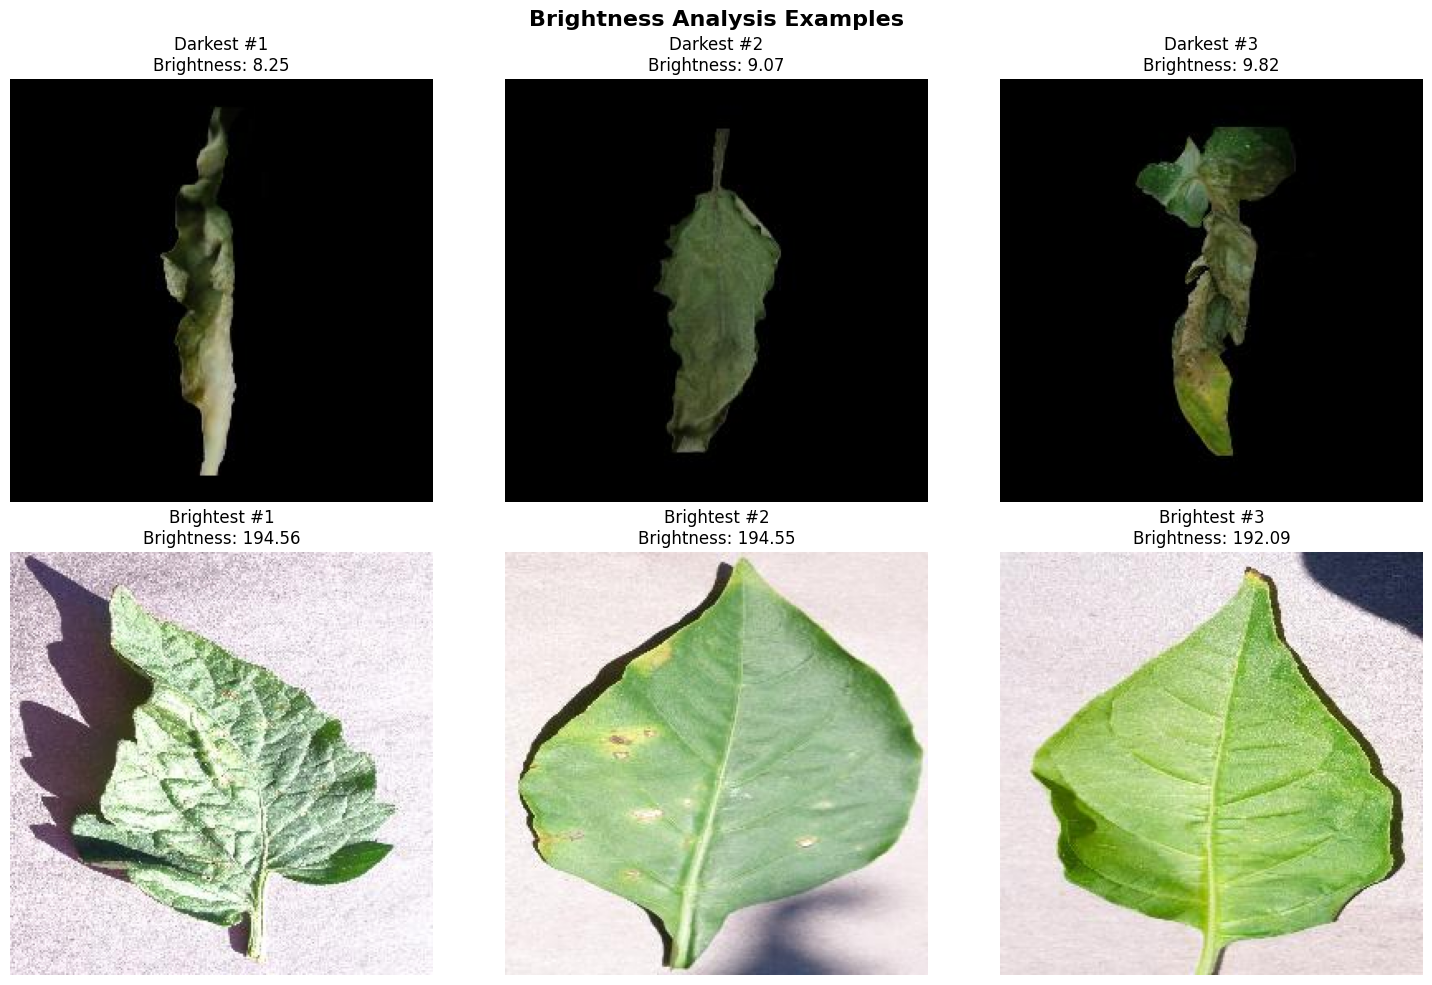

In [14]:
# Brightness Analysis
print("Analyzing brightness levels")

def analyze_brightness(image_path):
    """
    Analyze image brightness.
    Returns mean brightness (0-255)
    """
    image = cv2.imread(str(image_path))
    if image is None:
        return None
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return np.mean(gray)

# Analyze brightness for all images
brightness_scores = []
for img_path in all_images:
    brightness = analyze_brightness(img_path)
    brightness_scores.append(brightness if brightness is not None else 0)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram
axes[0].hist(brightness_scores, bins=50, color='orange', edgecolor='black', alpha=0.7)
axes[0].axvline(x=50, color='blue', linestyle='--', label='Too Dark (< 50)')
axes[0].axvline(x=200, color='red', linestyle='--', label='Too Bright (> 200)')
axes[0].set_xlabel('Mean Brightness (0-255)')
axes[0].set_ylabel('Number of Images')
axes[0].set_title('Brightness Distribution')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Box plot
axes[1].boxplot(brightness_scores, vert=True)
axes[1].set_ylabel('Mean Brightness')
axes[1].set_title('Brightness Distribution (Box Plot)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistics
too_dark = sum(1 for b in brightness_scores if b < 50)
too_bright = sum(1 for b in brightness_scores if b > 200)
print(f"\nBrightness Analysis Results:")
print(f"Mean brightness: {np.mean(brightness_scores):.2f}")
print(f"Median brightness: {np.median(brightness_scores):.2f}")
print(f"Std deviation: {np.std(brightness_scores):.2f}")
print(f"Too dark images (< 50): {too_dark} ({too_dark/len(brightness_scores)*100:.2f}%)")
print(f"Too bright images (> 200): {too_bright} ({too_bright/len(brightness_scores)*100:.2f}%)")

# Show examples
print("\nSample Images:")
sorted_indices = np.argsort(brightness_scores)
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Brightness Analysis Examples', fontsize=16, fontweight='bold')

for i in range(3):
    # Darkest
    idx = sorted_indices[i]
    img = Image.open(all_images[idx])
    axes[0, i].imshow(img)
    axes[0, i].set_title(f'Darkest #{i+1}\nBrightness: {brightness_scores[idx]:.2f}')
    axes[0, i].axis('off')
    
    # Brightest
    idx = sorted_indices[-(i+1)]
    img = Image.open(all_images[idx])
    axes[1, i].imshow(img)
    axes[1, i].set_title(f'Brightest #{i+1}\nBrightness: {brightness_scores[idx]:.2f}')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

# Store results
quality_results['brightness'] = brightness_scores

## Brightness Analysis
- **99.33%** of images have acceptable brightness and dataset is well-exposed overall.
- **138 images (0.67%)** are too dark (brightness < 50); visually these are near-black and should be **removed**.
- **0 images** are overexposed (brightness > 200) and no action needed on the bright end.
- Distribution is **tightly centred** around 118 (mean ≈ median), indicating consistent lighting conditions.
> **Action:** Remove the 138 dark images (brightness < 50). No action needed for overexposure.

Estimating noise levels


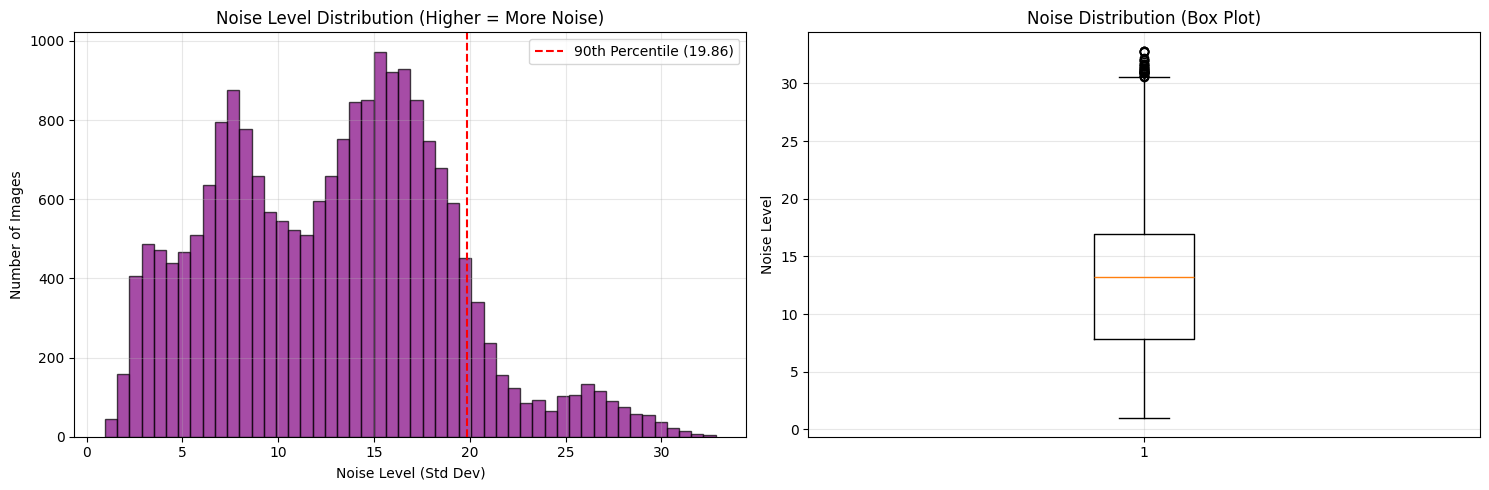


Noise Analysis Results:
Mean noise level: 12.85
Median noise level: 13.24
Std deviation: 6.01
High noise images (> 90th percentile): 2064 (10.00%)

Sample Images:


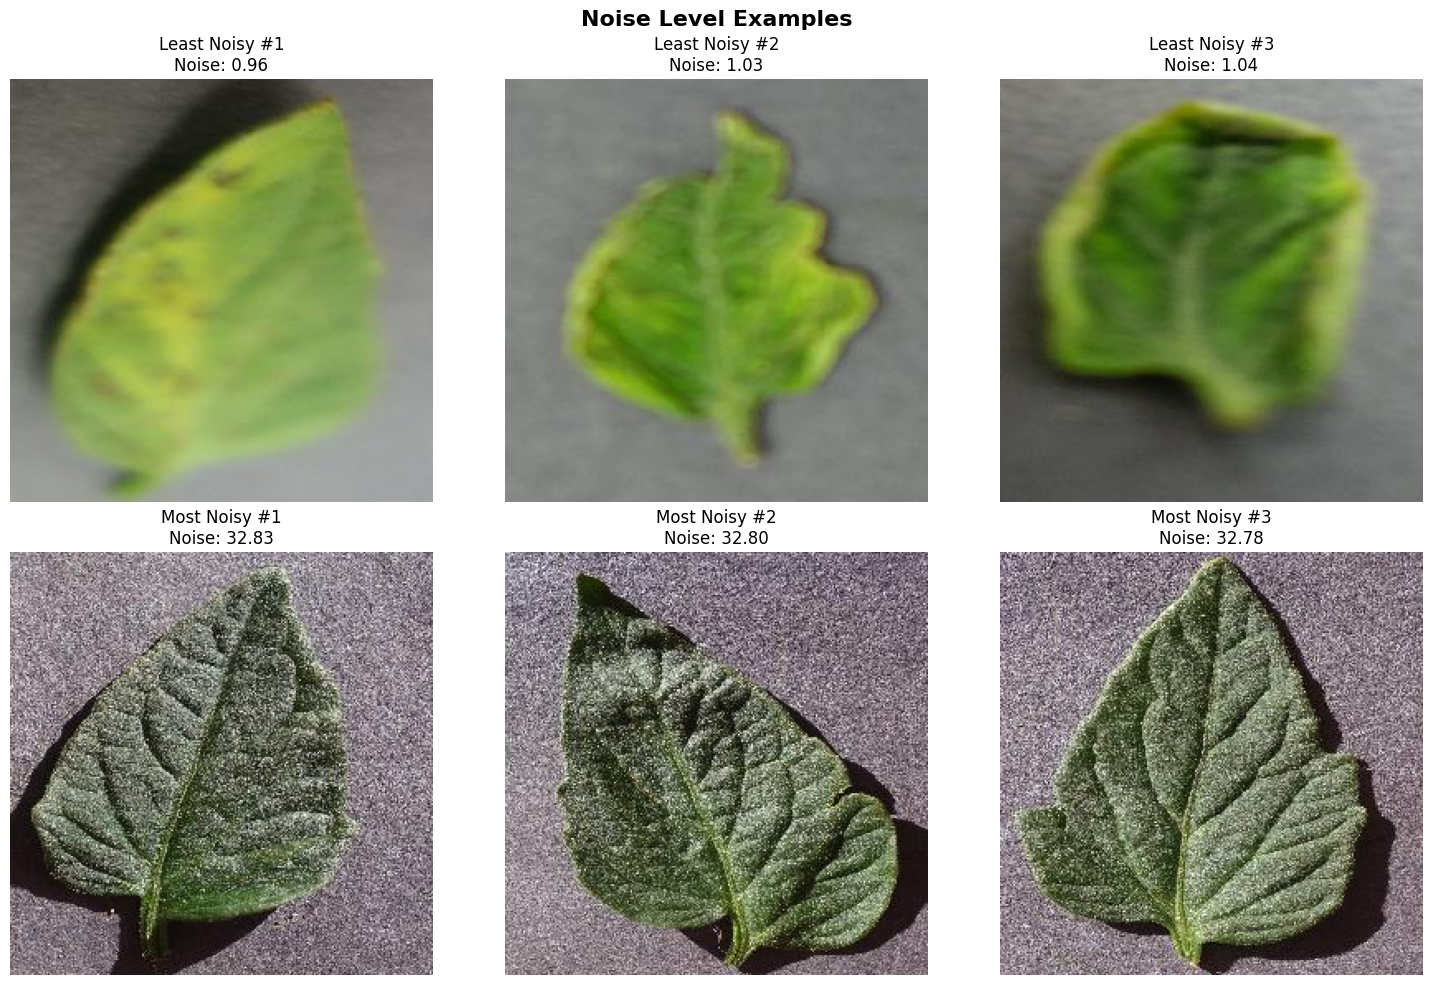

In [13]:
# Noise Level Estimation
print("Estimating noise levels")

def estimate_noise(image_path):
    """
    Estimate noise level using Local Std Deviation.
    Higher values = more noise
    """
    image = cv2.imread(str(image_path))
    if image is None:
        return None
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Use local standard deviation as noise estimate
    # Apply Gaussian blur and subtract from original
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    noise = gray.astype(float) - blurred.astype(float)
    noise_level = np.std(noise)
    
    return noise_level

# Analyze noise for all images
noise_scores = []
for img_path in all_images:
    noise = estimate_noise(img_path)
    noise_scores.append(noise if noise is not None else 0)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram
axes[0].hist(noise_scores, bins=50, color='purple', edgecolor='black', alpha=0.7)
axes[0].axvline(x=np.percentile(noise_scores, 90), color='red', linestyle='--', 
                label=f'90th Percentile ({np.percentile(noise_scores, 90):.2f})')
axes[0].set_xlabel('Noise Level (Std Dev)')
axes[0].set_ylabel('Number of Images')
axes[0].set_title('Noise Level Distribution (Higher = More Noise)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Box plot
axes[1].boxplot(noise_scores, vert=True)
axes[1].set_ylabel('Noise Level')
axes[1].set_title('Noise Distribution (Box Plot)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistics
noise_threshold = np.percentile(noise_scores, 90)
high_noise_count = sum(1 for n in noise_scores if n > noise_threshold)
print(f"\nNoise Analysis Results:")
print(f"Mean noise level: {np.mean(noise_scores):.2f}")
print(f"Median noise level: {np.median(noise_scores):.2f}")
print(f"Std deviation: {np.std(noise_scores):.2f}")
print(f"High noise images (> 90th percentile): {high_noise_count} ({high_noise_count/len(noise_scores)*100:.2f}%)")

# Show examples
print("\nSample Images:")
sorted_indices = np.argsort(noise_scores)
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Noise Level Examples', fontsize=16, fontweight='bold')

for i in range(3):
    # Least noisy
    idx = sorted_indices[i]
    img = Image.open(all_images[idx])
    axes[0, i].imshow(img)
    axes[0, i].set_title(f'Least Noisy #{i+1}\nNoise: {noise_scores[idx]:.2f}')
    axes[0, i].axis('off')
    
    # Most noisy
    idx = sorted_indices[-(i+1)]
    img = Image.open(all_images[idx])
    axes[1, i].imshow(img)
    axes[1, i].set_title(f'Most Noisy #{i+1}\nNoise: {noise_scores[idx]:.2f}')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

# Store results
quality_results['noise_level'] = noise_scores

## Noise Analysis Key Findings

- Noise levels are **low and consistent**  mean ≈ median (~13), std dev only 6.01.
- The histogram shows a **bimodal distribution** one cluster of naturally smooth images (~1–5) and a larger cluster of moderately noisy images (~10–20).
- **2,064 images (10%)** exceed the 90th percentile threshold (noise > 19.86) and these are noisy but **not necessarily unusable**.
- Visually, the "Most Noisy" images (~32–33) show heavy grain/texture noise from rough backgrounds, but leaf features remain visible.
- The "Least Noisy" images (~1) overlap with the **blurry** images identified earlier and low noise + low blur score = out-of-focus, not truly clean.

> **Action:** Do **not** remove high-noise images outright. Instead, apply **denoising augmentation** (e.g., Gaussian smoothing) during training to improve model robustness. Flag the top 10% for closer inspection if accuracy issues arise.

Calculating sharpness metrics


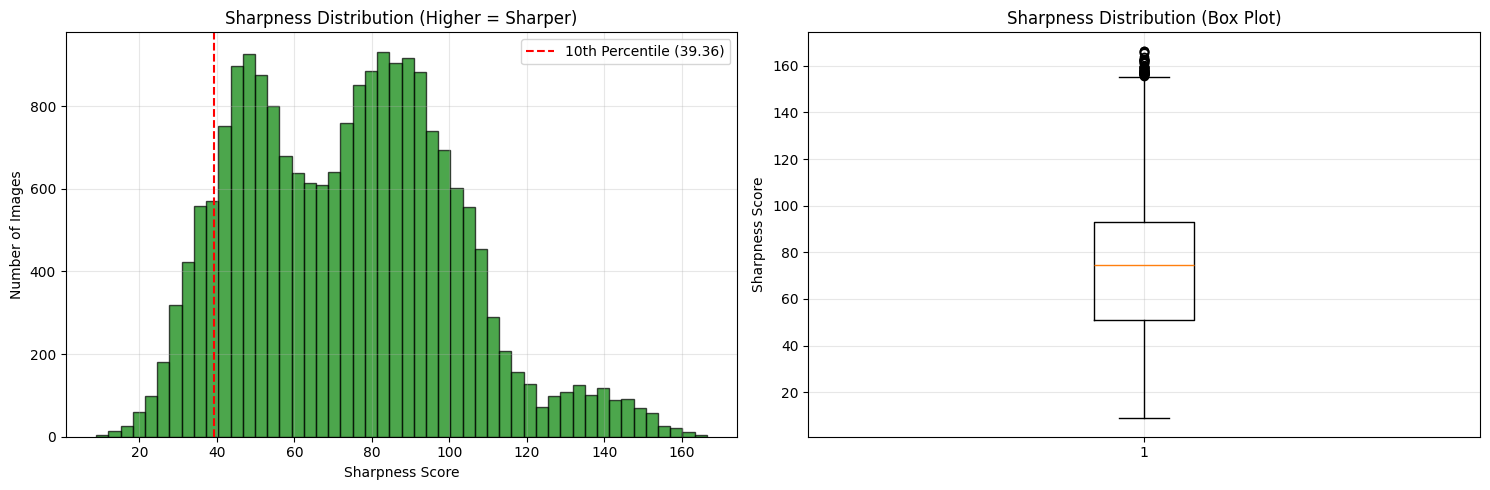


Sharpness Analysis Results:
Mean sharpness: 74.03
Median sharpness: 74.52
Std deviation: 27.62
Low sharpness images (< 10th percentile): 2064 (10.00%)

Sample Images:


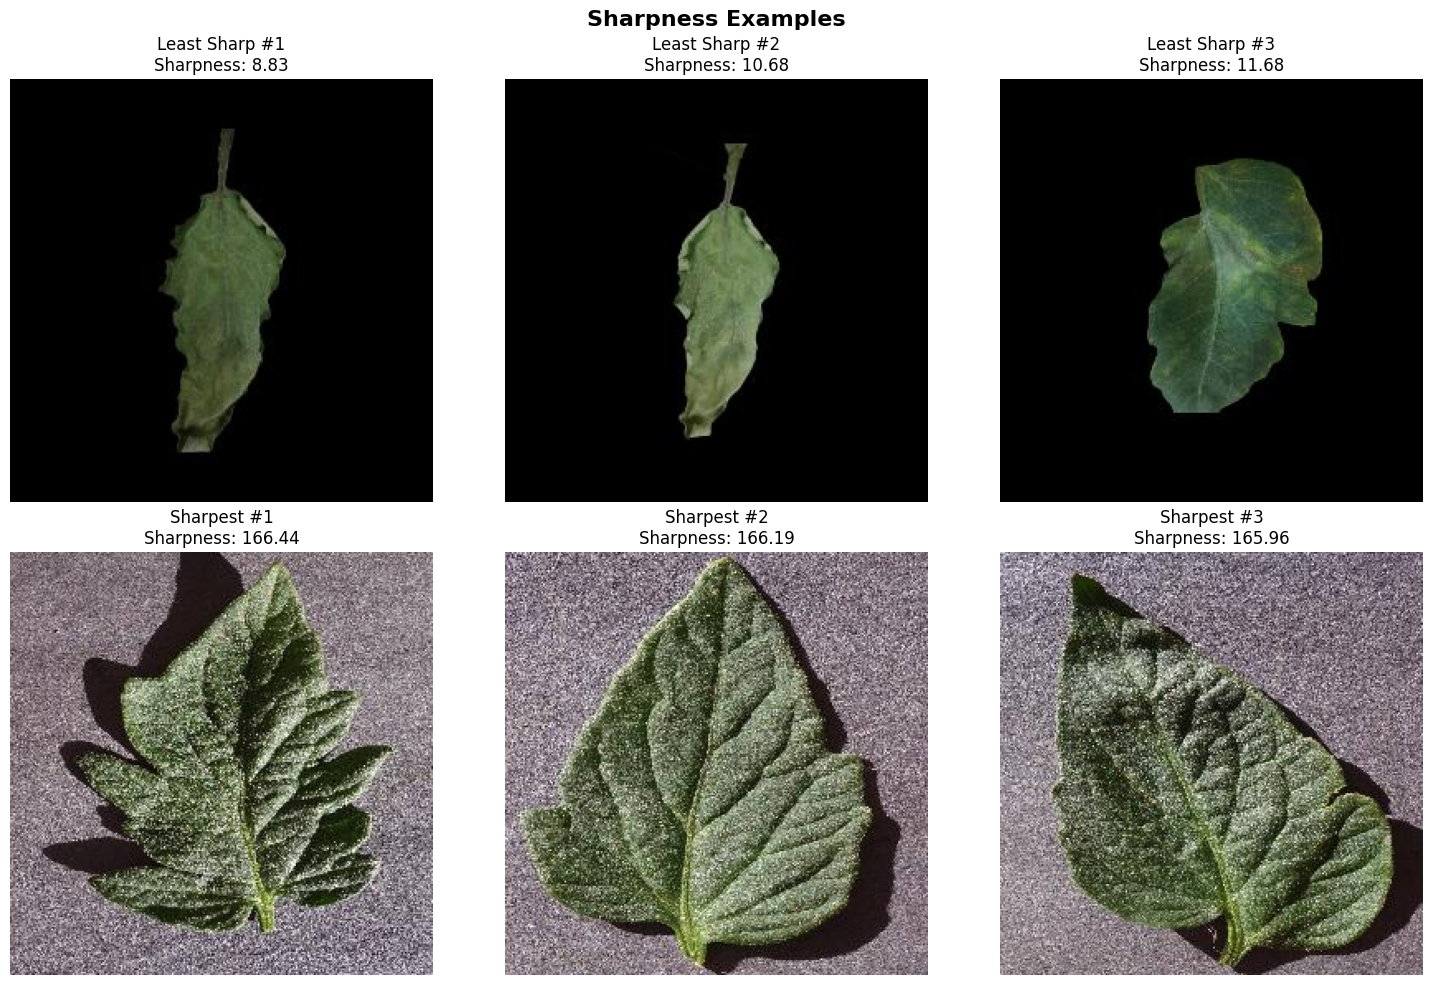

In [12]:
# Sharpness Metrics
print("Calculating sharpness metrics")

def calculate_sharpness(image_path):
    """
    Calculate sharpness using gradient magnitude.
    Higher values = sharper edges
    """
    image = cv2.imread(str(image_path))
    if image is None:
        return None
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Calculate gradients
    gx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    gy = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    
    # Calculate gradient magnitude
    gradient_magnitude = np.sqrt(gx**2 + gy**2)
    sharpness = np.mean(gradient_magnitude)
    
    return sharpness

# Analyze sharpness for all images
sharpness_scores = []
for img_path in all_images:
    sharpness = calculate_sharpness(img_path)
    sharpness_scores.append(sharpness if sharpness is not None else 0)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram
axes[0].hist(sharpness_scores, bins=50, color='green', edgecolor='black', alpha=0.7)
axes[0].axvline(x=np.percentile(sharpness_scores, 10), color='red', linestyle='--', 
                label=f'10th Percentile ({np.percentile(sharpness_scores, 10):.2f})')
axes[0].set_xlabel('Sharpness Score')
axes[0].set_ylabel('Number of Images')
axes[0].set_title('Sharpness Distribution (Higher = Sharper)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Box plot
axes[1].boxplot(sharpness_scores, vert=True)
axes[1].set_ylabel('Sharpness Score')
axes[1].set_title('Sharpness Distribution (Box Plot)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistics
sharpness_threshold = np.percentile(sharpness_scores, 10)
low_sharpness_count = sum(1 for s in sharpness_scores if s < sharpness_threshold)
print(f"\nSharpness Analysis Results:")
print(f"Mean sharpness: {np.mean(sharpness_scores):.2f}")
print(f"Median sharpness: {np.median(sharpness_scores):.2f}")
print(f"Std deviation: {np.std(sharpness_scores):.2f}")
print(f"Low sharpness images (< 10th percentile): {low_sharpness_count} ({low_sharpness_count/len(sharpness_scores)*100:.2f}%)")

# Show examples
print("\nSample Images:")
sorted_indices = np.argsort(sharpness_scores)
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Sharpness Examples', fontsize=16, fontweight='bold')

for i in range(3):
    # Least sharp
    idx = sorted_indices[i]
    img = Image.open(all_images[idx])
    axes[0, i].imshow(img)
    axes[0, i].set_title(f'Least Sharp #{i+1}\nSharpness: {sharpness_scores[idx]:.2f}')
    axes[0, i].axis('off')
    
    # Sharpest
    idx = sorted_indices[-(i+1)]
    img = Image.open(all_images[idx])
    axes[1, i].imshow(img)
    axes[1, i].set_title(f'Sharpest #{i+1}\nSharpness: {sharpness_scores[idx]:.2f}')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

# Store results
quality_results['sharpness'] = sharpness_scores

Sharpness levels are moderate overall and fairly centered (mean: 74.03, median: 74.52).
Variation is meaningful (std dev: 27.62), so image clarity is not uniform across the dataset.
2,064 images (10%) fall below the 10th percentile threshold and represent the blurriest subset.
Visual checks show low-sharpness samples have weaker edge detail and reduced texture clarity, which can hide disease cues.
Blurry images can hurt detection of fine symptoms, but low sharpness does not always mean unusable.
Action: Do not remove all low-sharpness images directly. First inspect the worst subset (e.g., bottom 1–3%), then keep most samples and use blur augmentation during training to improve robustness.

Computing combined quality scores


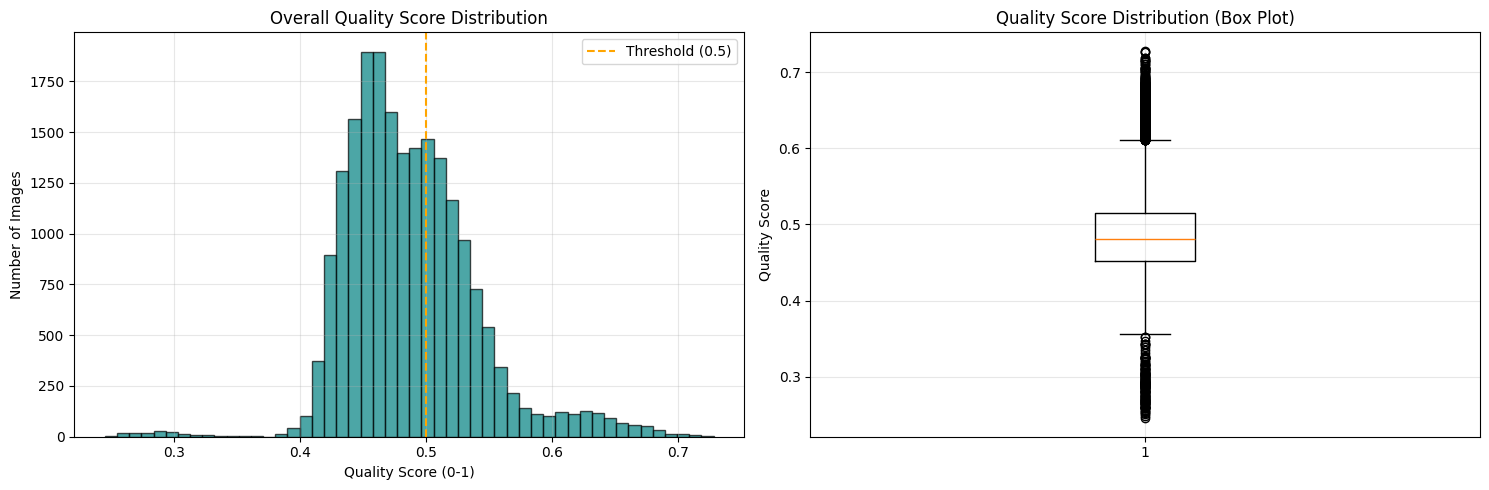


Overall Quality Analysis:
Mean quality score: 0.487
Median quality score: 0.480
Std deviation: 0.053
Low quality images (< 0.5): 13219 (64.05%)

Sample Images:


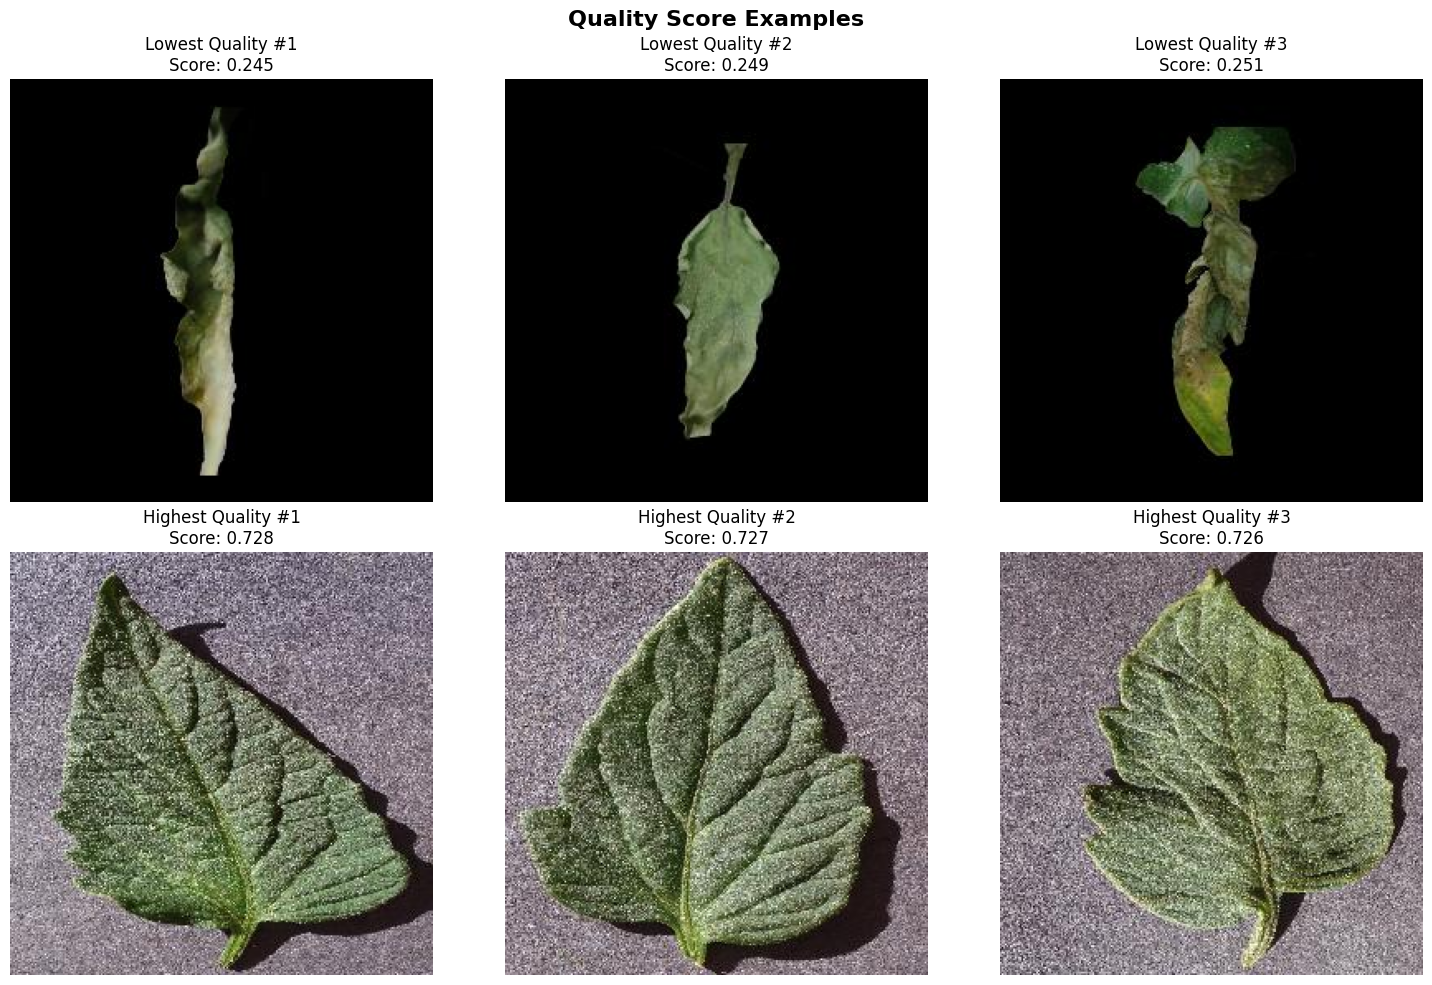


DataFrame created with 20637 images


In [11]:
# Combined Quality Score
print("Computing combined quality scores")

# Normalize all metrics to 0-1 scale
blur_normalized = (np.array(blur_scores) - np.min(blur_scores)) / (np.max(blur_scores) - np.min(blur_scores))
brightness_normalized = 1 - np.abs(np.array(brightness_scores) - 127.5) / 127.5  # Penalize extremes
noise_normalized = 1 - (np.array(noise_scores) - np.min(noise_scores)) / (np.max(noise_scores) - np.min(noise_scores))
sharpness_normalized = (np.array(sharpness_scores) - np.min(sharpness_scores)) / (np.max(sharpness_scores) - np.min(sharpness_scores))

# Compute weighted quality score
weights = {
    'blur': 0.3,
    'brightness': 0.2,
    'noise': 0.25,
    'sharpness': 0.25
}

quality_scores = (
    weights['blur'] * blur_normalized +
    weights['brightness'] * brightness_normalized +
    weights['noise'] * noise_normalized +
    weights['sharpness'] * sharpness_normalized
)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram
axes[0].hist(quality_scores, bins=50, color='teal', edgecolor='black', alpha=0.7)
axes[0].axvline(x=0.5, color='orange', linestyle='--', label='Threshold (0.5)')
axes[0].set_xlabel('Quality Score (0-1)')
axes[0].set_ylabel('Number of Images')
axes[0].set_title('Overall Quality Score Distribution')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Box plot
axes[1].boxplot(quality_scores, vert=True)
axes[1].set_ylabel('Quality Score')
axes[1].set_title('Quality Score Distribution (Box Plot)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistics
quality_threshold = 0.5
low_quality_count = sum(1 for q in quality_scores if q < quality_threshold)
print(f"\nOverall Quality Analysis:")
print(f"Mean quality score: {np.mean(quality_scores):.3f}")
print(f"Median quality score: {np.median(quality_scores):.3f}")
print(f"Std deviation: {np.std(quality_scores):.3f}")
print(f"Low quality images (< {quality_threshold}): {low_quality_count} ({low_quality_count/len(quality_scores)*100:.2f}%)")

# Show examples
print("\nSample Images:")
sorted_indices = np.argsort(quality_scores)
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Quality Score Examples', fontsize=16, fontweight='bold')

for i in range(3):
    # Lowest quality
    idx = sorted_indices[i]
    img = Image.open(all_images[idx])
    axes[0, i].imshow(img)
    axes[0, i].set_title(f'Lowest Quality #{i+1}\nScore: {quality_scores[idx]:.3f}')
    axes[0, i].axis('off')
    
    # Highest quality
    idx = sorted_indices[-(i+1)]
    img = Image.open(all_images[idx])
    axes[1, i].imshow(img)
    axes[1, i].set_title(f'Highest Quality #{i+1}\nScore: {quality_scores[idx]:.3f}')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

# Add to results
quality_results['image_path'] = all_images
quality_results['class_name'] = class_names
quality_results['quality_score'] = quality_scores

# Create DataFrame
df_quality = pd.DataFrame(quality_results)
print(f"\nDataFrame created with {len(df_quality)} images")

### Overall Quality Analysis Key Findings
- **Overall quality** is centered near the threshold (mean: 0.487, median: 0.480), so many images lie close to the cutoff.
- **Variation** is moderate and controlled (std: 0.053), indicating mostly consistent quality levels.
- **13,219 images (64.05%)** fall below 0.5, so this threshold is likely too aggressive for filtering.
- Most images appear concentrated in the mid-quality band (roughly 0.43-0.53), with fewer extreme outliers.
- Low-score samples tend to show blur/low detail, while high-score samples show clear edges and texture.

### Implication
A hard rule of `quality < 0.5` = remove will likely discard too much useful training data and may hurt class balance.

### Recommended Action
Use a tiered filtering strategy instead of a single hard cutoff:

- **Keep:** >= 0.45
- **Review:** 0.40-0.45
- **Remove only extreme outliers:** < 0.40 (after visual + class-balance checks)

Add quality-aware sampling/weighting and blur/noise augmentation during training to improve robustness.

Analyzing quality distribution per class

Quality Statistics by Class:
                                             quality_score_mean  \
class_name                                                        
Tomato_healthy                                            0.568   
Potato___healthy                                          0.524   
Tomato__Target_Spot                                       0.522   
Potato___Early_blight                                     0.521   
Tomato_Spider_mites_Two_spotted_spider_mite               0.517   
Tomato__Tomato_mosaic_virus                               0.503   
Pepper__bell___Bacterial_spot                             0.495   
Tomato_Septoria_leaf_spot                                 0.490   
Pepper__bell___healthy                                    0.486   
Potato___Late_blight                                      0.481   
Tomato_Leaf_Mold                                          0.474   
Tomato_Early_blight                                       

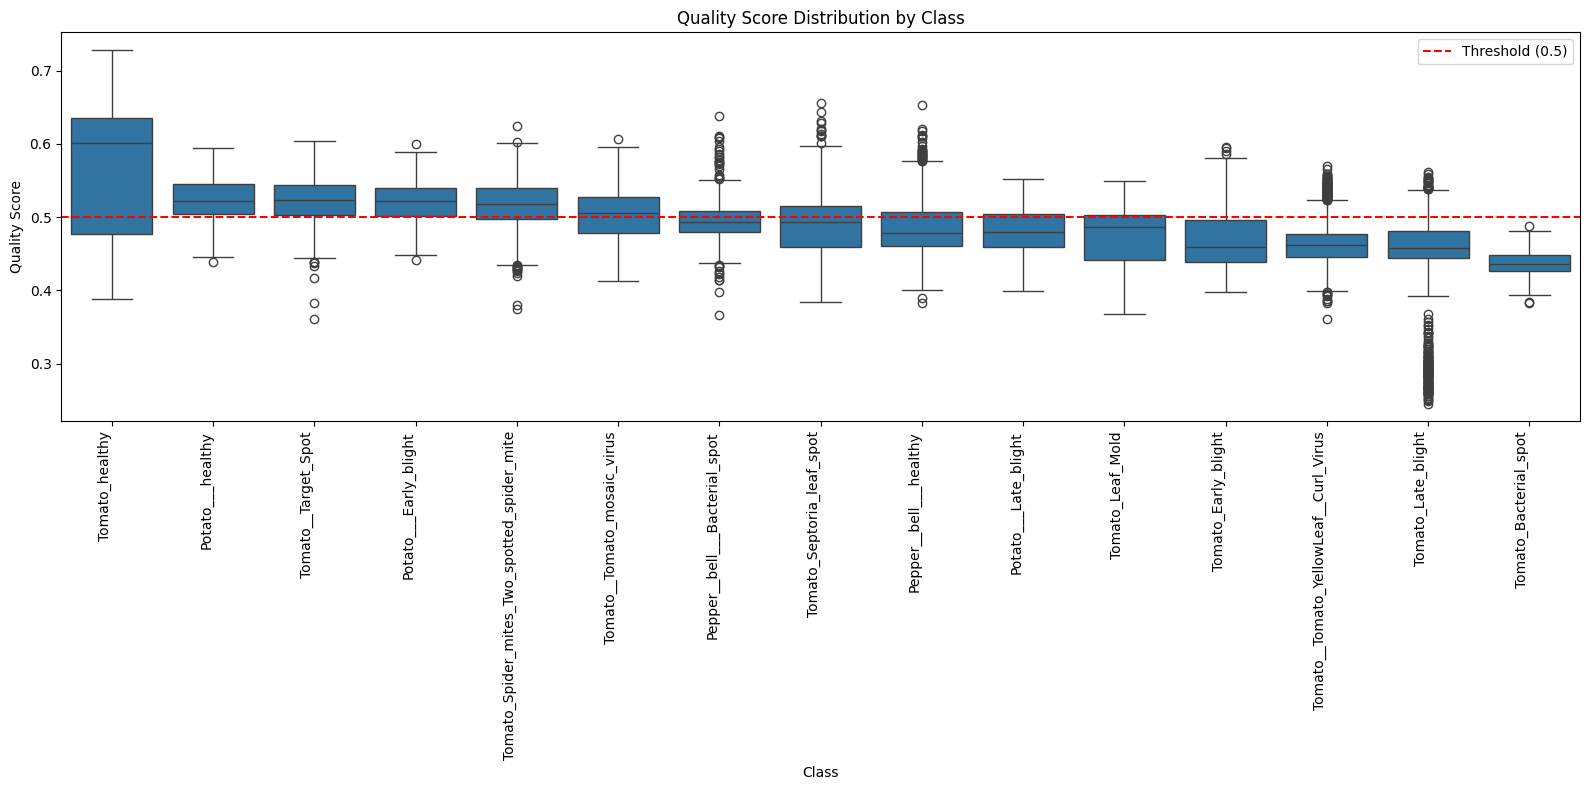

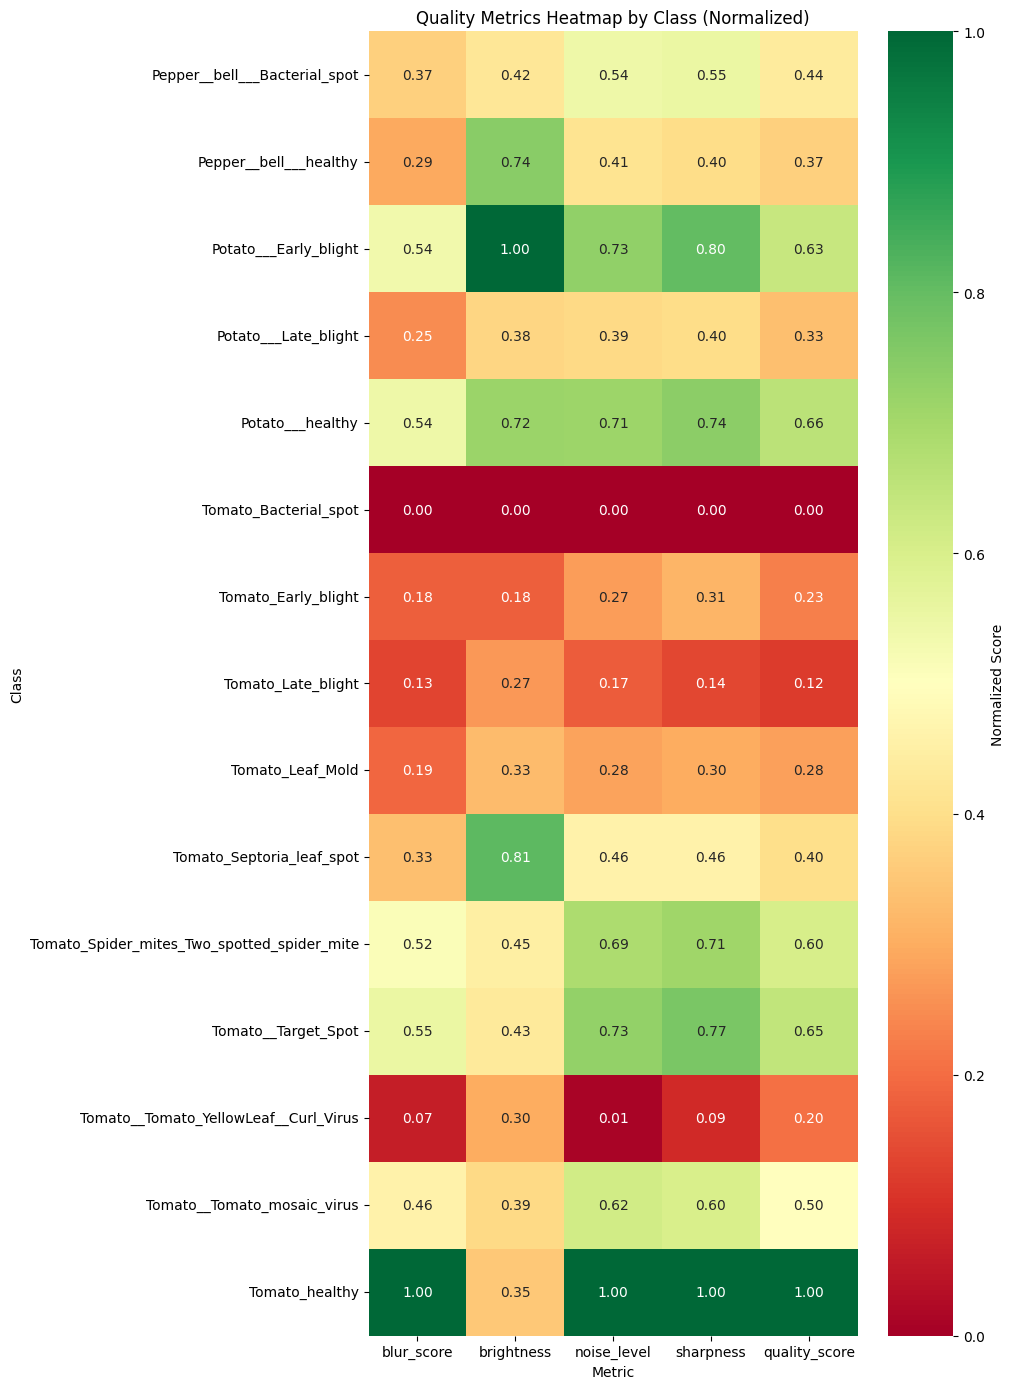


Classes with Quality Issues:
Tomato_healthy: Mean quality = 0.568
  Blur issues: 0 images
  Brightness issues: 0 images
  Noise issues: 979 images

Potato___healthy: Mean quality = 0.524
  Blur issues: 0 images
  Brightness issues: 0 images
  Noise issues: 32 images

Tomato__Target_Spot: Mean quality = 0.522
  Blur issues: 0 images
  Brightness issues: 1 images
  Noise issues: 297 images

Potato___Early_blight: Mean quality = 0.521
  Blur issues: 0 images
  Brightness issues: 0 images
  Noise issues: 131 images

Tomato_Spider_mites_Two_spotted_spider_mite: Mean quality = 0.517
  Blur issues: 0 images
  Brightness issues: 0 images
  Noise issues: 250 images


Quality analysis saved to: ../data/processed/quality_analysis.csv


In [10]:
# Quality Distribution by Class
print("Analyzing quality distribution per class")

# Calculate statistics per class
class_quality_stats = df_quality.groupby('class_name').agg({
    'quality_score': ['mean', 'median', 'std', 'min', 'max', 'count'],
    'blur_score': 'mean',
    'brightness': 'mean',
    'noise_level': 'mean',
    'sharpness': 'mean'
}).round(3)

# Flatten column names
class_quality_stats.columns = ['_'.join(col).strip() for col in class_quality_stats.columns.values]
class_quality_stats = class_quality_stats.sort_values('quality_score_mean', ascending=False)

print("\nQuality Statistics by Class:")
print(class_quality_stats)

# Visualization 1: Box plot of quality scores by class
plt.figure(figsize=(16, 8))
class_order = class_quality_stats.index.tolist()
sns.boxplot(data=df_quality, x='class_name', y='quality_score', order=class_order)
plt.xticks(rotation=90, ha='right')
plt.xlabel('Class')
plt.ylabel('Quality Score')
plt.title('Quality Score Distribution by Class')
plt.axhline(y=0.5, color='r', linestyle='--', label='Threshold (0.5)')
plt.legend()
plt.tight_layout()
plt.show()

# Visualization 2: Heatmap of all metrics by class
metrics_by_class = df_quality.groupby('class_name')[['blur_score', 'brightness', 'noise_level', 'sharpness', 'quality_score']].mean()
metrics_normalized = (metrics_by_class - metrics_by_class.min()) / (metrics_by_class.max() - metrics_by_class.min())

plt.figure(figsize=(10, 14))
sns.heatmap(metrics_normalized, annot=True, fmt='.2f', cmap='RdYlGn', cbar_kws={'label': 'Normalized Score'})
plt.title('Quality Metrics Heatmap by Class (Normalized)')
plt.xlabel('Metric')
plt.ylabel('Class')
plt.tight_layout()
plt.show()

# Identify problematic classes
print("\nClasses with Quality Issues:")
for class_name in class_quality_stats.index[:5]:
    stats = class_quality_stats.loc[class_name]
    mean_quality = stats['quality_score_mean']
    if mean_quality < 0.6:
        print(f"{class_name}: Mean quality = {mean_quality:.3f}")
        
        # Find specific issues
        class_data = df_quality[df_quality['class_name'] == class_name]
        blur_issues = (class_data['blur_score'] < 100).sum()
        brightness_issues = ((class_data['brightness'] < 50) | (class_data['brightness'] > 200)).sum()
        noise_issues = (class_data['noise_level'] > np.percentile(noise_scores, 90)).sum()
        
        print(f"  Blur issues: {blur_issues} images")
        print(f"  Brightness issues: {brightness_issues} images")
        print(f"  Noise issues: {noise_issues} images\n")

# Save results
output_path = Path("../data/processed/quality_analysis.csv")
output_path.parent.mkdir(parents=True, exist_ok=True)
df_quality.to_csv(output_path, index=False)
print(f"\nQuality analysis saved to: {output_path}")

### Class-wise Quality Issues: Key Findings

The listed classes have acceptable mean quality scores (0.517–0.568), so the problem is not a global class failure.

### Main Issue
The dominant issue is clearly **noise**, not blur or brightness:
- **Tomato_healthy**: 979 noise issues
- **Tomato__Target_Spot**: 297 noise issues
- **Tomato_Spider_mites_Two_spotted_spider_mite**: 250 noise issues
- **Potato___Early_blight**: 131 noise issues
- **Potato___healthy**: 32 noise issues

Blur and brightness flags are near zero in these classes, so filtering should be noise-targeted.

### Implication
A generic quality filter would remove many usable images; this is a class-specific noise distribution shift.
- **Tomato_healthy** has the largest noisy subset, which can bias the model to learn background/grain patterns.

### Recommended Action
- Apply class-aware denoising augmentation (light Gaussian blur/median filtering) during training.
- Keep images by default; only review/remove extreme noise outliers after visual checks.
- Add per-class sampling/weighting so noisy-heavy classes do not dominate learning signals.
- Track validation metrics by class after denoising to confirm improvement.

In [17]:
# Load existing metadata if it exists
metadata_path = Path("../../data/metadata/dataset_metadata.json")
metadata_path.parent.mkdir(parents=True, exist_ok=True)

if metadata_path.exists():
    with open(metadata_path, 'r') as f:
        metadata = json.load(f)
else:
    metadata = {}

# Add quality analysis results to metadata
metadata['quality_analysis'] = {
    'analysis_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'total_images_analyzed': len(all_images),
    'blur_analysis': {
        'mean_score': float(np.mean(blur_scores)),
        'median_score': float(np.median(blur_scores)),
        'threshold': 100,
        'blurry_images': int(sum(1 for score in blur_scores if score < 100)),
        'blurry_percentage': float(sum(1 for score in blur_scores if score < 100) / len(blur_scores) * 100)
    },
    'brightness_analysis': {
        'mean_brightness': float(np.mean(brightness_scores)),
        'median_brightness': float(np.median(brightness_scores)),
        'too_dark': int(sum(1 for b in brightness_scores if b < 50)),
        'too_bright': int(sum(1 for b in brightness_scores if b > 200))
    },
    'noise_analysis': {
        'mean_noise': float(np.mean(noise_scores)),
        'median_noise': float(np.median(noise_scores)),
        'threshold': float(np.percentile(noise_scores, 90)),
        'high_noise_images': int(sum(1 for n in noise_scores if n > np.percentile(noise_scores, 90)))
    },
    'sharpness_analysis': {
        'mean_sharpness': float(np.mean(sharpness_scores)),
        'median_sharpness': float(np.median(sharpness_scores)),
        'threshold': float(np.percentile(sharpness_scores, 10)),
        'low_sharpness_images': int(sum(1 for s in sharpness_scores if s < np.percentile(sharpness_scores, 10)))
    },
    'overall_quality': {
        'mean_quality_score': float(np.mean(quality_scores)),
        'median_quality_score': float(np.median(quality_scores)),
        'threshold': 0.5,
        'low_quality_images': int(sum(1 for q in quality_scores if q < 0.5)),
        'low_quality_percentage': float(sum(1 for q in quality_scores if q < 0.5) / len(quality_scores) * 100)
    },
    'quality_weights': {
        'blur': 0.3,
        'brightness': 0.2,
        'noise': 0.25,
        'sharpness': 0.25
    }
}

# Save class-level quality statistics
class_quality_dict = class_quality_stats.to_dict('index')
metadata['quality_by_class'] = {
    class_name: {
        'mean_quality': float(stats['quality_score_mean']),
        'median_quality': float(stats['quality_score_median']),
        'std_quality': float(stats['quality_score_std']),
        'image_count': int(stats['quality_score_count'])
    }
    for class_name, stats in class_quality_dict.items()
}

# Save updated metadata
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=4)

print(f"Quality metadata saved to: {metadata_path}")

Quality metadata saved to: ../../data/metadata/dataset_metadata.json
